# **ТИПиС - ИДЗ№3 - Воропаев Илья 3391**



In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import warnings
import joblib
warnings.filterwarnings('ignore')

In [7]:
# Загрузка данных
train_df = pd.read_csv('diamonds_train.csv')
test_df = pd.read_csv('diamonds_test.csv')

In [8]:
print("Размер тренировочных данных:", train_df.shape)
print("Размер тестовых данных:", test_df.shape)
print("\nПервые 5 строк тренировочных данных:")
print(train_df.head())

Размер тренировочных данных: (43018, 10)
Размер тестовых данных: (5379, 10)

Первые 5 строк тренировочных данных:
   carat        cut color clarity  depth  table  price     x     y     z
0   0.51       Good     D     SI2   63.9   55.0   1180  5.04  5.10  3.24
1   0.72      Ideal     E     VS2   60.8   57.0   3091  5.79  5.82  3.53
2   0.70  Very Good     D    VVS2   62.8   60.0   4022  5.65  5.69  3.56
3   0.36      Ideal     D     SI1   61.2   57.0    663  4.59  4.63  2.82
4   0.54  Very Good     D     SI1   60.0   59.8   1593  5.30  5.34  3.18


In [9]:
# Анализ данных
def explore_data(df):
    print("=== АНАЛИЗ ДАННЫХ ===")
    print(f"Общая информация:")
    print(f"Количество записей: {df.shape[0]}")
    print(f"Количество признаков: {df.shape[1]}")

    print(f"\nПропущенные значения:")
    print(df.isnull().sum())

    print(f"\nТипы данных:")
    print(df.dtypes)

    print(f"\nСтатистика числовых признаков:")
    print(df.describe())

    if 'price' in df.columns:
        print(f"\nСтатистика целевой переменной (price):")
        print(f"Среднее: ${df['price'].mean():.2f}")
        print(f"Медиана: ${df['price'].median():.2f}")
        print(f"Стандартное отклонение: ${df['price'].std():.2f}")
        print(f"Минимум: ${df['price'].min():.2f}")
        print(f"Максимум: ${df['price'].max():.2f}")

explore_data(train_df)

=== АНАЛИЗ ДАННЫХ ===
Общая информация:
Количество записей: 43018
Количество признаков: 10

Пропущенные значения:
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

Типы данных:
carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

Статистика числовых признаков:
              carat         depth         table         price             x  \
count  43018.000000  43018.000000  43018.000000  43018.000000  43018.000000   
mean       0.796818     61.749672     57.456648   3929.500442      5.730426   
std        0.471362      1.427265      2.238806   3985.321605      1.116451   
min        0.200000     43.000000     43.000000    326.000000      3.730000   
25%        0.400000     61.000000     56.000000    951.000000      4.720000   
50%        0.700000

In [10]:
# Анализ категориальных переменных
def analyze_categorical(df):
    cat_cols = ['cut', 'color', 'clarity']

    print("=== КАТЕГОРИАЛЬНЫЕ ПЕРЕМЕННЫЕ ===")
    for col in cat_cols:
        print(f"\n{col}:")
        print(f"Уникальные значения: {sorted(df[col].unique())}")
        print(f"Количество уникальных значений: {df[col].nunique()}")
        value_counts = df[col].value_counts()
        for val, count in value_counts.items():
            print(f"  {val}: {count} ({count/len(df)*100:.1f}%)")

analyze_categorical(train_df)

=== КАТЕГОРИАЛЬНЫЕ ПЕРЕМЕННЫЕ ===

cut:
Уникальные значения: ['Fair', 'Good', 'Ideal', 'Premium', 'Very Good']
Количество уникальных значений: 5
  Ideal: 17189 (40.0%)
  Premium: 10993 (25.6%)
  Very Good: 9652 (22.4%)
  Good: 3903 (9.1%)
  Fair: 1281 (3.0%)

color:
Уникальные значения: ['D', 'E', 'F', 'G', 'H', 'I', 'J']
Количество уникальных значений: 7
  G: 9009 (20.9%)
  E: 7853 (18.3%)
  F: 7608 (17.7%)
  H: 6627 (15.4%)
  D: 5407 (12.6%)
  I: 4318 (10.0%)
  J: 2196 (5.1%)

clarity:
Уникальные значения: ['I1', 'IF', 'SI1', 'SI2', 'VS1', 'VS2', 'VVS1', 'VVS2']
Количество уникальных значений: 8
  SI1: 10445 (24.3%)
  VS2: 9779 (22.7%)
  SI2: 7284 (16.9%)
  VS1: 6560 (15.2%)
  VVS2: 4031 (9.4%)
  VVS1: 2919 (6.8%)
  IF: 1419 (3.3%)
  I1: 581 (1.4%)


In [11]:
# Feature Engineering
def create_features(df):
    df = df.copy()

    # Базовые признаки
    df['volume'] = df['x'] * df['y'] * df['z']
    df['density'] = df['carat'] / (df['volume'] + 1e-6)  # избегаем деления на 0
    df['table_depth_ratio'] = df['table'] / df['depth']
    df['avg_dimension'] = (df['x'] + df['y'] + df['z']) / 3

    # Дополнительные геометрические признаки
    df['surface_area'] = 2 * (df['x']*df['y'] + df['x']*df['z'] + df['y']*df['z'])
    df['x_y_ratio'] = df['x'] / (df['y'] + 1e-6)
    df['x_z_ratio'] = df['x'] / (df['z'] + 1e-6)
    df['y_z_ratio'] = df['y'] / (df['z'] + 1e-6)

    # Признаки, основанные на carat
    df['carat_squared'] = df['carat'] ** 2
    df['carat_cubed'] = df['carat'] ** 3

    return df

# Применяем feature engineering
train_processed = create_features(train_df)
test_processed = create_features(test_df)

In [12]:
print("Признаки после feature engineering:")
print(train_processed.columns.tolist())
print(f"Количество признаков: {len(train_processed.columns)}")

Признаки после feature engineering:
['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z', 'volume', 'density', 'table_depth_ratio', 'avg_dimension', 'surface_area', 'x_y_ratio', 'x_z_ratio', 'y_z_ratio', 'carat_squared', 'carat_cubed']
Количество признаков: 20


In [13]:
# Кодирование категориальных переменных
def encode_categorical(df):
    df = df.copy()

    # Порядковое кодирование на основе качества
    cut_mapping = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
    color_mapping = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}
    clarity_mapping = {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}

    df['cut_encoded'] = df['cut'].map(cut_mapping)
    df['color_encoded'] = df['color'].map(color_mapping)
    df['clarity_encoded'] = df['clarity'].map(clarity_mapping)

    return df

train_encoded = encode_categorical(train_processed)
test_encoded = encode_categorical(test_processed)

In [14]:
print("После кодирования категориальных переменных:")
print(train_encoded[['cut', 'cut_encoded', 'color', 'color_encoded', 'clarity', 'clarity_encoded']].head())

После кодирования категориальных переменных:
         cut  cut_encoded color  color_encoded clarity  clarity_encoded
0       Good            2     D              7     SI2                2
1      Ideal            5     E              6     VS2                4
2  Very Good            3     D              7    VVS2                6
3      Ideal            5     D              7     SI1                3
4  Very Good            3     D              7     SI1                3


In [15]:
# Подготовка данных для обучения
def prepare_data(df, is_train=True):
    # Удаляем исходные категориальные колонки
    cols_to_drop = ['cut', 'color', 'clarity']
    if 'id' in df.columns:
        cols_to_drop.append('id')

    if is_train:
        X = df.drop(cols_to_drop + ['price'], axis=1)
        y = df['price']
        return X, y
    else:
        X = df.drop(cols_to_drop, axis=1)
        return X

X, y = prepare_data(train_encoded, is_train=True)
X_test = prepare_data(test_encoded, is_train=False)

# Заполняем возможные пропуски
X = X.fillna(X.median())
X_test = X_test.fillna(X.median())

In [16]:
print(f"Финальные размеры данных:")
print(f"X: {X.shape}, y: {y.shape}")
print(f"X_test: {X_test.shape}")
print(f"Используемые признаки: {list(X.columns)}")

Финальные размеры данных:
X: (43018, 19), y: (43018,)
X_test: (5379, 19)
Используемые признаки: ['carat', 'depth', 'table', 'x', 'y', 'z', 'volume', 'density', 'table_depth_ratio', 'avg_dimension', 'surface_area', 'x_y_ratio', 'x_z_ratio', 'y_z_ratio', 'carat_squared', 'carat_cubed', 'cut_encoded', 'color_encoded', 'clarity_encoded']


In [17]:
# Разделение на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Разделение данных:")
print(f"Train: {X_train.shape}")
print(f"Validation: {X_val.shape}")

Разделение данных:
Train: (34414, 19)
Validation: (8604, 19)


In [18]:
# Обучение и оценка моделей
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    # Обучение
    model.fit(X_train, y_train)

    # Предсказания
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Метрики
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    print(f"\n=== {model_name} ===")
    print(f"RMSE - Train: ${train_rmse:.2f}, Val: ${val_rmse:.2f}")
    print(f"R²   - Train: {train_r2:.4f}, Val: {val_r2:.4f}")
    print(f"MAE  - Train: ${train_mae:.2f}, Val: ${val_mae:.2f}")

    # Кросс-валидация
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print(f"Cross-val R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    return {
        'model': model,
        'val_rmse': val_rmse,
        'val_r2': val_r2,
        'val_mae': val_mae
    }

In [19]:
# Тестируем разные модели
models_results = {}

In [27]:
# 1. Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
models_results['Random Forest'] = evaluate_model(rf_model, X_train, X_val, y_train, y_val, 'Random Forest')


=== Random Forest ===
RMSE - Train: $368.94, Val: $594.39
R²   - Train: 0.9914, Val: 0.9781
MAE  - Train: $178.21, Val: $277.72
Cross-val R²: 0.9806 (+/- 0.0032)


In [24]:
# 2. Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
models_results['Gradient Boosting'] = evaluate_model(gb_model, X_train, X_val, y_train, y_val, 'Gradient Boosting')


=== Gradient Boosting ===
RMSE - Train: $399.03, Val: $547.04
R²   - Train: 0.9899, Val: 0.9815
MAE  - Train: $222.22, Val: $268.92
Cross-val R²: 0.9825 (+/- 0.0022)


In [29]:
# Выбор лучшей модели
best_model_name = min(models_results.items(), key=lambda x: x[1]['val_rmse'])[0]
best_model = models_results[best_model_name]['model']

print(f"\nЛучшая модель: {best_model_name}")
print(f"RMSE на валидации: ${models_results[best_model_name]['val_rmse']:.2f}")
print(f"R² на валидации: {models_results[best_model_name]['val_r2']:.4f}")


Лучшая модель: Gradient Boosting
RMSE на валидации: $547.04
R² на валидации: 0.9815


Топ-10 самых важных признаков:
            feature  importance
6            volume    0.310051
4                 y    0.254853
10     surface_area    0.161103
18  clarity_encoded    0.064524
9     avg_dimension    0.063818
15      carat_cubed    0.057077
17    color_encoded    0.033464
14    carat_squared    0.017812
0             carat    0.017462
5                 z    0.011161


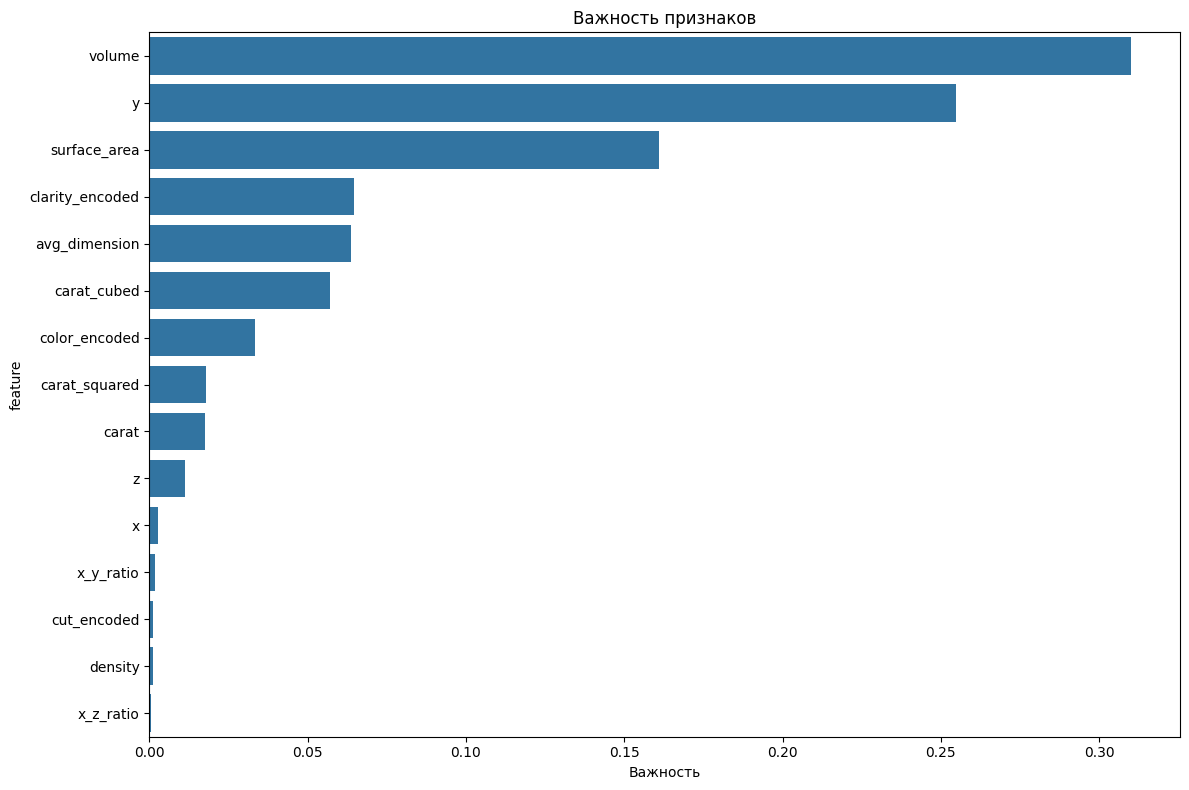

In [30]:
# Анализ важности признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Топ-10 самых важных признаков:")
print(feature_importance.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

In [32]:
# Финальное обучение на всех данных
print("=== ФИНАЛЬНАЯ МОДЕЛЬ ===")
final_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

final_model.fit(X, y)

# Оценка на всех данных
final_predictions = final_model.predict(X)
final_rmse = np.sqrt(mean_squared_error(y, final_predictions))
final_r2 = r2_score(y, final_predictions)

print(f"RMSE на всех данных: ${final_rmse:.2f}")
print(f"R² на всех данных: {final_r2:.4f}")

=== ФИНАЛЬНАЯ МОДЕЛЬ ===
RMSE на всех данных: $418.66
R² на всех данных: 0.9890


In [33]:
# Предсказание на тестовых данных
test_predictions = final_model.predict(X_test)

# Создание submission файла
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'price': test_predictions
})

# Сохранение результатов
submission_df.to_csv('diamonds_price_prediction.csv', index=False)

print("=== РЕЗУЛЬТАТЫ ===")
print(f"Размер submission файла: {submission_df.shape}")
print(f"Статистика предсказаний:")
print(f"Минимальная цена: ${test_predictions.min():.2f}")
print(f"Максимальная цена: ${test_predictions.max():.2f}")
print(f"Средняя цена: ${test_predictions.mean():.2f}")
print(f"Медианная цена: ${np.median(test_predictions):.2f}")
print(f"\nПервые 5 предсказаний:")
print(submission_df.head())

=== РЕЗУЛЬТАТЫ ===
Размер submission файла: (5379, 2)
Статистика предсказаний:
Минимальная цена: $304.36
Максимальная цена: $18342.12
Средняя цена: $3931.85
Медианная цена: $2447.80

Первые 5 предсказаний:
   id        price
0   0  4152.336305
1   1  2408.574522
2   2   797.903553
3   3  1190.059695
4   4   864.793536


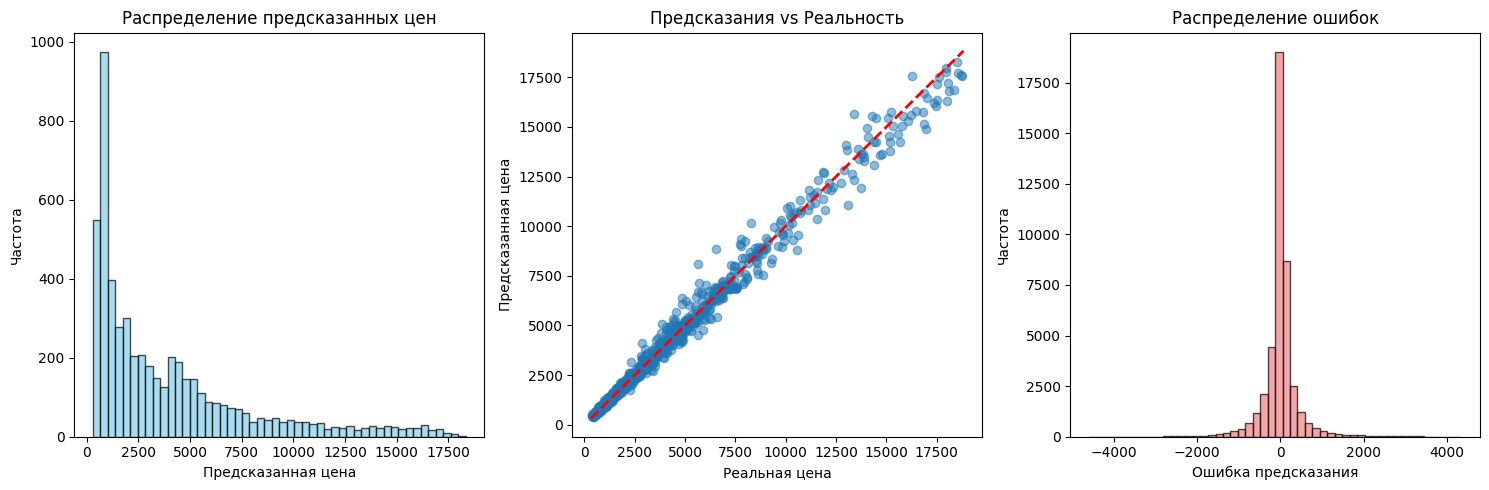

In [34]:
# Визуализация результатов
plt.figure(figsize=(15, 5))

# 1. Распределение предсказаний
plt.subplot(1, 3, 1)
plt.hist(test_predictions, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Предсказанная цена')
plt.ylabel('Частота')
plt.title('Распределение предсказанных цен')

# 2. Сравнение с реальными ценами (на тренировочных данных)
plt.subplot(1, 3, 2)
sample_idx = np.random.choice(len(y), 1000, replace=False)
plt.scatter(y.iloc[sample_idx], final_predictions[sample_idx], alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Реальная цена')
plt.ylabel('Предсказанная цена')
plt.title('Предсказания vs Реальность')

# 3. Ошибки предсказания
plt.subplot(1, 3, 3)
errors = final_predictions - y
plt.hist(errors, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Ошибка предсказания')
plt.ylabel('Частота')
plt.title('Распределение ошибок')

plt.tight_layout()
plt.show()